In [1]:
import numpy as np
import qutip as qtp
import matplotlib.pyplot as plt
from scipy import constants
import pysqkit
from pysqkit import QubitSystem
import pysqkit.util.transformations as trf
from pysqkit.util.linalg import get_mat_elem

import qutip
from typing import List, Dict
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import copy
import json

from IPython.display import display, Latex

In [2]:
with open("flx_transm_params.txt") as my_file:
    parameters_set = json.load(my_file)

In [3]:
p_set = "CR_3"


#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=parameters_set[p_set]["max_freq_t"], 
    anharm=parameters_set[p_set]["anharm_t"],
    diel_loss_tan=None, 
    env_thermal_energy=None,    
    dim_hilbert=levels_t,
    dephasing_times=None
)

#Fluxonium
levels_f = 6

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=parameters_set[p_set]["charge_energy_f"], 
    induct_energy=parameters_set[p_set]["induct_energy_f"], 
    joseph_energy=parameters_set[p_set]["joseph_energy_f"], 
    diel_loss_tan=parameters_set[p_set]["diel_loss_tan_f"], 
    env_thermal_energy=None,
    dephasing_times=None
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cr_drive_f',
    pulse=pysqkit.drives.pulses.cos_modulation,
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

jc = parameters_set[p_set]["jc"]
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

states_label = coupled_sys.all_state_labels()
states_dict = coupled_sys.states_as_dict(as_qobj=True)



In [4]:
levels_to_plot = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04']

ground_energy = bare_system.state('00')[0]
energy = {}
state = {}
x_avg = {}

for level in levels_to_plot:
    energy[level] = bare_system.state(level)[0] - ground_energy
    state[level] = bare_system.state(level)[1]

qubit_labels = bare_system.labels
n1n2_op = bare_system[qubit_labels[0]].charge_op().dot(bare_system[qubit_labels[1]].charge_op())
abs_mat_elem_list = []
count = 0
for level_1 in levels_to_plot:
    for level_2 in levels_to_plot:
        abs_mat_elem_list.append(np.abs(get_mat_elem(n1n2_op, state[level_1], state[level_2])))
max_abs_mat_elem = max(abs_mat_elem_list)

abs_mat_elem = {}

for level_1 in levels_to_plot:
        for level_2 in levels_to_plot:
            abs_mat_elem[level_1 + "_" + level_2] = np.abs(get_mat_elem(n1n2_op, state[level_1], state[level_2]))

my_data = {}
my_data["energy"] = energy
my_data["abs_mat_elem"] = abs_mat_elem

In [5]:
def energy_levels_diagram(
    energy: dict,
    abs_mat_elem: dict,
    levels_to_plot: List[str],
    plot_setup={'fs': 20, 'lw': 2.0, 'lw_levels': 3.0, 'ls': 18},
    detuning_tol=3.0,
    show_drive=True,
    save=False
) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    step = 11.0
    level_width = 5.0
    x_avg = {}
    
    for level in levels_to_plot:
        level_as_list = [int(lev) for lev in level]
        x_min = -0.5 + step*level_as_list[1] - step*level_as_list[0]
        x_max = x_min + level_width
        x_avg[level] = (x_min + x_max)/2
        ax.hlines(y=energy[level], xmin=x_min, xmax=x_max, 
                  linewidth=plot_setup['lw_levels'], color='k')
        ax.text(x_max+0.2, energy[level]-0.05, r'$ \vert' + level + 
                ' \\rangle_0$', fontsize=plot_setup['fs'], zorder=10)
        y_ticks = [x*2 for x in range(7)]
        ax.set_yticks(y_ticks)
        y_ticks_latex = ['$0$', '$2$', '$4$', '$6$', '$8$', '$10$', '$12$']
        ax.set_yticklabels(y_ticks_latex)
        ax.tick_params(labelsize=plot_setup['ls'])
        ax.axes.get_xaxis().set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    
    max_abs_mat_elem = max([abs_mat_elem[key] for key in abs_mat_elem.keys()])
    for level_1 in levels_to_plot:
        for level_2 in levels_to_plot:
            shade_factor = abs_mat_elem[level_1 + "_" + level_2]/max_abs_mat_elem
            if shade_factor > 1e-4 and np.abs(energy[level_1] - \
                energy[level_2]) < detuning_tol:
                ax.annotate('', (x_avg[level_1], energy[level_1]), \
                            (x_avg[level_2], energy[level_2]), 
                            arrowprops=dict(color='darkorange', 
                            alpha=shade_factor**3, 
                            lw=plot_setup['lw'], arrowstyle='<->'))
                
    if show_drive:
        ax.annotate('', (x_avg['10'], energy['10']), 
                    (x_avg['13'], energy['13']), 
                    arrowprops=dict(color='darkblue', lw=plot_setup['lw'],
                    arrowstyle='<->', linestyle = '--'))
        ax.annotate('', (x_avg['00'], energy['00']), 
                    (x_avg['03'], energy['03']), 
                    arrowprops=dict(color='darkblue', lw=plot_setup['lw'],
                    arrowstyle='<->', linestyle = '--'))
        
    ax.set_title(r'$\mathrm{Transmon} \leftarrow \quad \rightarrow'
                 r'\mathrm{Fluxonium}$', {'fontsize': plot_setup['fs']})
    ax.set_ylabel(r'$\mathrm{Energy} \, (\mathrm{GHz})$', 
                  fontsize=plot_setup['fs'])
    if save:
        plt.savefig("energy_diagram_trans_flx.svg")
    plt.show()  


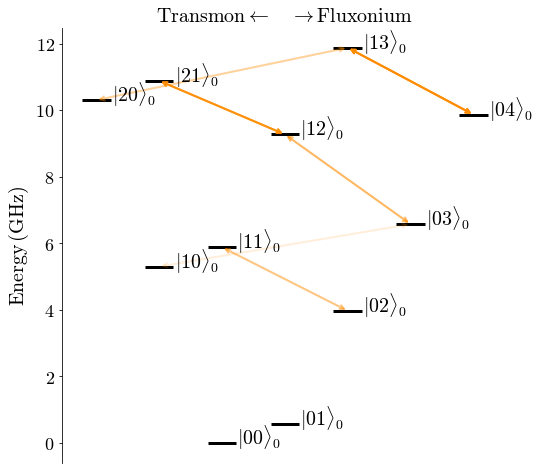

In [6]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04']

energy_levels_diagram(energy, abs_mat_elem, level_list, show_drive=False, save=False)

In [7]:
save = True
if save:
    with open('paper_plots/data_transmon_fluxonium/data_' + p_set + '.txt', 'w') as fp:
        json.dump(my_data, fp)